In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
import admix_prs
import admix
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
DATA_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/experiments/00-compile-data/out"
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"

TEST_COLS = ["SEX", "glasses"] + [
    col + "_Q"
    for col in ["AGE", "years_of_edu", "income", "DEPRIVATION_INDEX", "PC1", "PC2"]
]
COVAR_COLS = ["AGE", "SEX", "DEPRIVATION_INDEX"] + [f"PC{i}" for i in range(1, 11)]

print("Covariates:", ", ".join(COVAR_COLS))
print("Testing:", ", ".join(TEST_COLS))

Covariates: AGE, SEX, DEPRIVATION_INDEX, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10
Testing: SEX, glasses, AGE_Q, years_of_edu_Q, income_Q, DEPRIVATION_INDEX_Q, PC1_Q, PC2_Q


In [3]:
def load_trait_info(trait):

    ## 1. load trait and score
    df_trait = pd.read_csv(
        os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
    ).drop(columns=["IID"])

    df_score = pd.read_csv(
        os.path.join(DATA_DIR, f"pred/{trait}.score_summary.tsv.gz"),
        sep="\t",
        index_col=0,
    )
    df_score.index = [int(i.split("_")[0]) for i in df_score.index]

    ## 2. load covariates
    df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)

    # add some phenotype to the covariates
    for t in ["years_of_edu", "glasses", "income"]:
        df_tmp = pd.read_csv(
            os.path.join(PHENO_DIR, f"{t}.tsv"), sep="\t", index_col=0
        ).drop(columns=["IID"])
        df_covar[t] = df_tmp["PHENO"].reindex(df_covar.index)

    # convert continuous phenotype to discrete phenotypes
    for col in ["years_of_edu", "income", "AGE", "DEPRIVATION_INDEX", "PC1", "PC2"]:
        df_covar[f"{col}_Q"] = pd.qcut(df_covar[col], q=5, duplicates="drop").cat.codes

    # merge all files together
    df_trait = pd.merge(df_score, df_trait, left_index=True, right_index=True)
    df_trait = pd.merge(df_trait, df_covar, left_index=True, right_index=True)

    # restricted to UK ancestry
    df_trait = df_trait[df_trait.group == "United Kingdom"]
    df_trait = df_trait.dropna()
    return df_trait

In [4]:
def load_trait_r2_coverage(trait):
    np.random.seed(1234)

    df_trait = load_trait_info(trait)
    df_trait["PHENO_RESID"] = (
        sm.OLS(
            df_trait["PHENO"].values,
            sm.add_constant(df_trait[COVAR_COLS]),
            missing="drop",
        )
        .fit()
        .resid
    )
    df_baseline = admix_prs.summarize_pred(
        df_trait,
        y_col="PHENO_RESID",
        pred_col="MEAN",
    )
    ## calculate R2
    dict_r2 = {}
    for group_col in ["AGE_Q", "SEX"]:
        dict_r2[group_col] = admix_prs.summarize_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            group_col=group_col,
            n_bootstrap=1000,
            return_r2_diff=True,
        )

    ## calculate coverage after overall adjustment
    dict_coverage = {None: [], "AGE_Q": [], "SEX": []}

    for repeat_i in tqdm(range(100)):
        calibrate_idx = np.random.choice(
            df_trait.index, size=int(len(df_trait) * 0.1), replace=False
        ).tolist()
        test_idx = list(set(df_trait.index) - set(calibrate_idx))

        # perform calibration
        df_calibrated = admix_prs.calibrate_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            predstd_col="SD",
            calibrate_idx=calibrate_idx,
            ci_method="scale",
            ci=0.9,
        ).loc[test_idx, :]

        for col in ["PHENO_RESID", "AGE_Q", "SEX"]:
            df_calibrated[col] = df_trait[col].reindex(df_calibrated.index)
        for group_col in [None, "SEX", "AGE_Q"]:
            dict_coverage[group_col].append(
                admix_prs.summarize_pred(
                    df_calibrated,
                    y_col="PHENO_RESID",
                    pred_col="MEAN",
                    predstd_col="SD",
                    group_col=group_col,
                )
            )

    ## calculate coverage after adjust for both AGE and SEX
    dict_coverage2 = {None: [], "AGE_Q": [], "SEX": []}

    for repeat_i in tqdm(range(100)):
        calibrate_idx = np.random.choice(
            df_trait.index, size=int(len(df_trait) * 0.1), replace=False
        ).tolist()
        test_idx = list(set(df_trait.index) - set(calibrate_idx))

        # perform calibration
        df_calibrated = admix_prs.calibrate_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            predstd_col="SD",
            calibrate_idx=calibrate_idx,
            ci_method="scale",
            ci=0.9,
            ci_adjust_cols=["AGE", "SEX"],
        ).loc[test_idx, :]

        for col in ["PHENO_RESID", "AGE_Q", "SEX"]:
            df_calibrated[col] = df_trait[col].reindex(df_calibrated.index)
        for group_col in [None, "SEX", "AGE_Q"]:
            dict_coverage2[group_col].append(
                admix_prs.summarize_pred(
                    df_calibrated,
                    y_col="PHENO_RESID",
                    pred_col="MEAN",
                    predstd_col="SD",
                    group_col=group_col,
                )
            )

    return dict_r2, dict_coverage, dict_coverage2

In [5]:
def plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    trait,
    ylim_r2=None,
    ylim_cov=None,
    subfigure_mark=None,
):

    xlabel_map = {"AGE_Q": "Age quintile", "SEX": "Sex"}
    fig, axes = plt.subplots(
        figsize=(3.5, 3.5),
        dpi=150,
        nrows=2,
        ncols=2,
        sharex="col",
        sharey="row",
        gridspec_kw={"width_ratios": [5, 2]},
    )
    for i, group in enumerate(["AGE_Q", "SEX"]):
        ax = axes[0, i]
        df_res, df_res_se = dict_r2[group][0:2]
        n_group = df_res.shape[0]
        ax.errorbar(
            x=np.arange(n_group),
            y=df_res["r2"],
            yerr=df_res_se["r2"],
            fmt=".--",
            ms=4,
            mew=1,
            linewidth=1,
            color="black",
        )
        ax.set_xlim(-0.5, n_group - 0.5)
        if ylim_r2 is not None:
            ax.set_ylim(*ylim_r2)
        if i == 0:
            ax.set_ylabel(f"{trait} $R^2$")

    # coverage
    for i, group in enumerate(["AGE_Q", "SEX"]):
        ax = axes[1, i]

        ax.axhline(y=0.9, ls="--", lw=1.0, color="black", alpha=0.5)
        if ylim_cov is not None:
            ax.set_ylim(*ylim_cov)
        if i == 0:
            ax.set_ylabel(f"{trait} coverage")

        for cov_i, dict_cov in enumerate([dict_cov1, dict_cov2]):
            cov_vals = np.array([r["coverage"].values for r in dict_cov[group]])
            cov_mean, cov_sd = cov_vals.mean(axis=0), cov_vals.std(axis=0)
            n_group = cov_vals.shape[1]
            label = ["Overall", "By-cov"][cov_i]
            #             color = ["red", "blue"][cov_i]
            ax.errorbar(
                x=np.arange(n_group) - 0.1 + cov_i * 0.2,
                y=cov_mean,
                yerr=cov_sd,
                fmt=".--",
                ms=4,
                mew=1,
                linewidth=0.8,
                label=label,
            )
        ax.set_xticks(np.arange(n_group))
        ax.set_xlabel(xlabel_map[group])

    return fig, axes

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


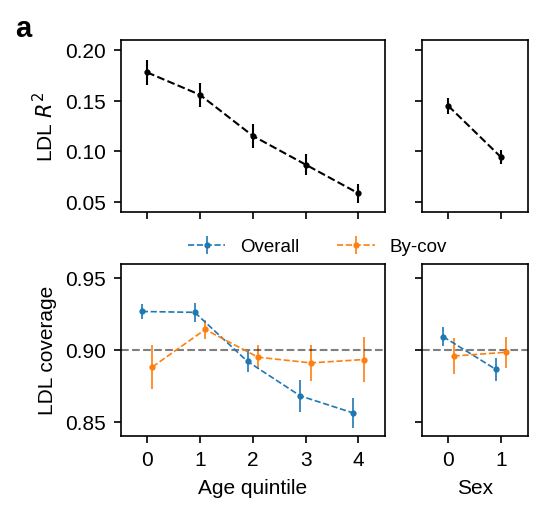

In [6]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage("LDL")

fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    trait="LDL",
    ylim_r2=[0.04, 0.21],
    ylim_cov=[0.84, 0.96],
)

handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
plt.subplots_adjust(hspace=0.3)

axes[0, 0].text(
    -0.4,
    1.02,
    "a",
    transform=axes[0, 0].transAxes,
    size=14,
    weight="bold",
)
fig.savefig("results/ldl.pdf", bbox_inches="tight")

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
 40%|████      | 40/100 [00:08<00:12,  4.68it/s]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


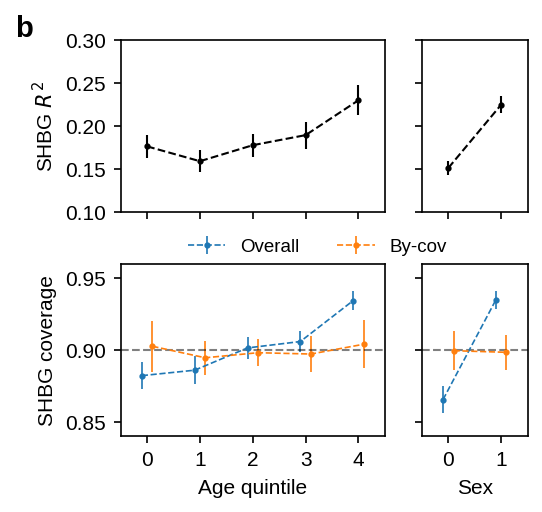

In [7]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage("log_SHBG")

fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    trait="SHBG",
    ylim_r2=[0.1, 0.3],
    ylim_cov=[0.84, 0.96],
)
handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
plt.subplots_adjust(hspace=0.3)

axes[0, 0].text(
    -0.4,
    1.02,
    "b",
    transform=axes[0, 0].transAxes,
    size=14,
    weight="bold",
)
fig.savefig("results/shbg.pdf", bbox_inches="tight")